**Load Data** (Configured differently so that train, val AND test set has x% of anomalies)

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7

USE_MIXED = True
USE_PRESSURE_TEMP = True
USE_SPECIFIC_CLOUDS = True
LOW_VIS_FRAC = True
low_vis_frac = 0.05
low_vis_threshold = 10000 #50000
cloud_types = [6] #0,1,2 ::: 0, 3, 4
noise_level = 0.01 # % of max
dnn_batch_size = 64

if USE_MIXED:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_mixed.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_mixed.dat', 'fog_data2_ir_water.dat']
else:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_water.dat']

target_i = 30 # Visibility index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset2/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset2/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.float32)

# 19 Data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)

# Cloud type index = 37
if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]


X = data_ir_vis[:, features_i]
y = data_ir_vis[:,target_i]

noise_std_devs = np.zeros(features_i.shape)

for i, feature_i in enumerate(features_i):
    noise_std = (np.max(data_ir_vis[:,feature_i]) - np.min(data_ir_vis[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))


if LOW_VIS_FRAC:

    low_vis_i = np.where(target_scaler.inverse_transform(y_scaled) < low_vis_threshold)[0]
    high_vis_i = np.where(target_scaler.inverse_transform(y_scaled) >= low_vis_threshold)[0]

    n_high_vis = int(len(low_vis_i) / low_vis_frac * (1 - low_vis_frac))
    print(f'real frac: {len(low_vis_i)/len(y_scaled)}')
    if n_high_vis > len(high_vis_i):
        n_high_vis = len(high_vis_i)
        n_low_vis = int(low_vis_frac * n_high_vis)
        r_low_vis_i = np.random.choice(low_vis_i, n_low_vis, replace=False)
        low_vis_i = r_low_vis_i
    print(f'n_low_vis: {len(low_vis_i)}. n_high_vis: {n_high_vis}')
    r_high_vis_i = np.random.choice(high_vis_i, n_high_vis, replace=False)

    X_temp = np.vstack([X_scaled[low_vis_i], X_scaled[r_high_vis_i]])
    y_temp = np.vstack([y_scaled[low_vis_i], y_scaled[r_high_vis_i]])


X_temp, X_test, y_temp, y_test = train_test_split(X_temp, y_temp, test_size=(1/19))
  

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(1/19))

# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_label = np.where(target_scaler.inverse_transform(y_train) < low_vis_threshold, 1, 0)
y_val_label = np.where(target_scaler.inverse_transform(y_val) < low_vis_threshold, 1, 0)
y_test_label = np.where(target_scaler.inverse_transform(y_test) < low_vis_threshold, 1, 0)

# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size=dnn_batch_size)
training_data_classes = tf.data.Dataset.from_tensor_slices((X_train, y_train_label)).batch(batch_size=dnn_batch_size)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_classes = training_data_classes.map(noise_map)


real frac: 0.1599519903980796
n_low_vis: 6299. n_high_vis: 125982


**KNN (K-Nearest Neighbours)**

/home/edgelab/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6653
           1       0.73      0.39      0.51       310

    accuracy                           0.97      6963
   macro avg       0.85      0.69      0.75      6963
weighted avg       0.96      0.97      0.96      6963



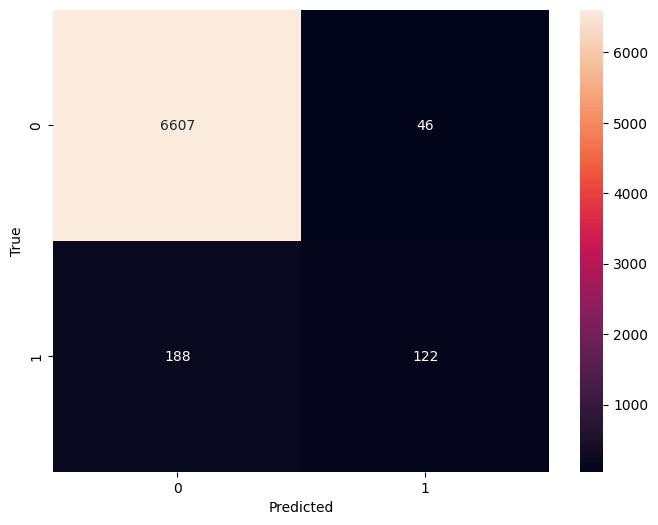

Nr. of predictied anomalies: 168
Nr. of actual anomalies:310


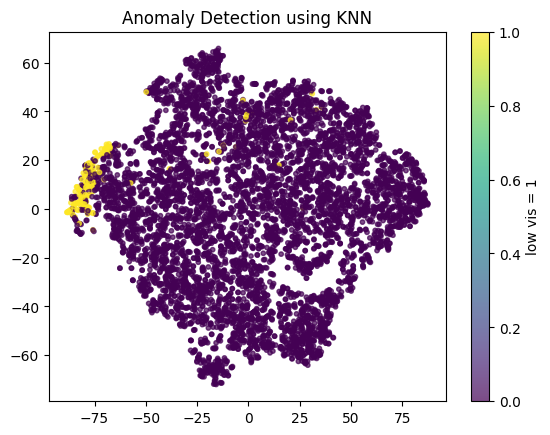

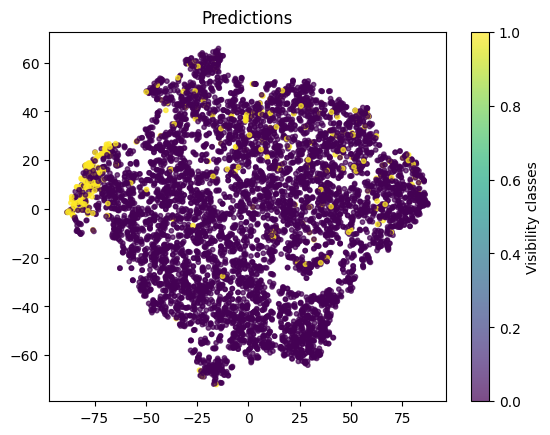

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_noisy, y_train_label)

# Predict whether each data point is an anomaly (0 for anomalies, 1 for normal data)
predictions = clf.predict(X_test_noisy)

print(classification_report(y_test_label, predictions))
cm = confusion_matrix(y_test_label, predictions)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(f'Nr. of predictied anomalies: {np.sum(predictions)}')
print(f'Nr. of actual anomalies:{np.sum(y_test_label)}')

# Initialize t-SNE model with desired parameters
tsne = TSNE(n_components=2, random_state=16)

# Fit and transform the data to 2 dimensions
X_tsne = tsne.fit_transform(X_test_noisy)                                                                           #UMAP

# Visualize the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=predictions, cmap='viridis', s = 10, alpha=0.7)
plt.colorbar(label="low vis = 1")
plt.title("Anomaly Detection using KNN")
plt.show()

# Visualize the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test_label, cmap='viridis', s = 10, alpha=0.7)
plt.colorbar(label="Visibility classes")
plt.title("Predictions")
plt.show()

**Isolation Forest**

0.16274665944811376
0.16274665944811376
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6653
           1       0.00      0.00      0.00       310

    accuracy                           0.91      6963
   macro avg       0.48      0.47      0.48      6963
weighted avg       0.91      0.91      0.91      6963



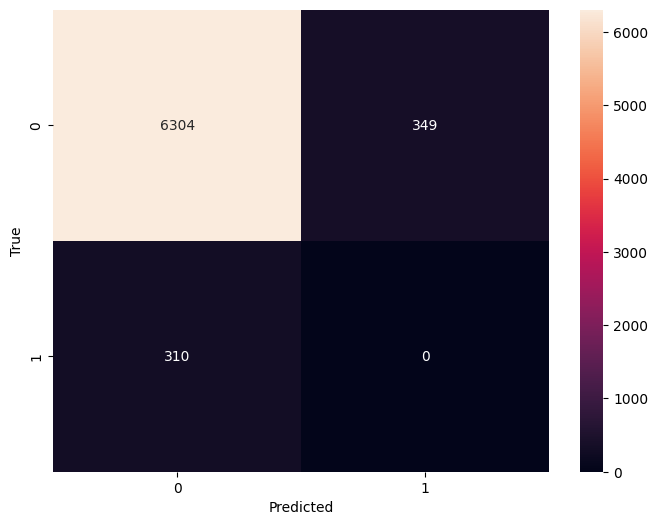

In [5]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Create an Isolation Forest model
fog_frac = np.sum(y_test_label) / len(y_test_label)

isolation_forest = IsolationForest(contamination=fog_frac)  # Set contamination to your expected proportion of anomalies

# Train the model
isolation_forest.fit(X_train_noisy, y_train_label)  # Including labels during training

# Predict outliers/anomalies
anomaly_scores = isolation_forest.decision_function(X_test_noisy)


threshold = np.percentile(anomaly_scores, 95)  # RUN THRESHOLD LOOP HERE

print(threshold)

predicted_labels = np.where(anomaly_scores < threshold, 0, 1)  # Anomalies marked as 1, normal instances marked as -1

print(threshold)
# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test_label, predicted_labels))
cm = confusion_matrix(y_test_label, predicted_labels)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**One Class SVM (Support Vector Machine)**

In [6]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, average_precision_score


# Train One-Class SVM
ocsvm = OneClassSVM(gamma='auto')
#ocsvm.fit(X_train_noisy[np.where(y_train_label == 0)[0]])  # Fit on high vis pixels only
ocsvm.fit(X_train_noisy)  # Fit on all pixels


# Predict anomaly scores
anomaly_scores = ocsvm.decision_function(X_test_noisy)


thresholds = np.arange(-2000, 1000, 50)
avg_precisions = np.zeros(thresholds.shape)
accuracies = np.zeros(thresholds.shape)

# Loop to check different thresholds
for i, t in enumerate(thresholds):
    predicted_labels = (anomaly_scores < t).astype(int)
    avg_precisions[i] = average_precision_score(y_test_label, predicted_labels)
    accuracies[i] = accuracy_score(y_test_label, predicted_labels)


print(f'Accurcy: {np.max(accuracies)} at t = {thresholds[np.argmax(accuracies)]}')
print(f'Avg Precision: {np.max(avg_precisions)} at t = {thresholds[np.argmax(avg_precisions)]}')

# print(classification_report(y_test_label, predicted_labels))
# cm = confusion_matrix(y_test_label, predicted_labels)
# plt.figure(figsize=(8,6)) 
# sn.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()


**Autoencoder for Anomaly Detection**

In [ ]:
import numpy as np
import tensorflow as tf
from keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 32

input_data = tf.keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_data)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train_noisy, y_train_label, epochs=50, batch_size=128, validation_split=0.2)

# Define reconstruction error threshold
reconstruction_errors = np.mean(np.square(X_test_noisy - autoencoder.predict(X_test_noisy)), axis=1)
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)

# Predict anomalies based on the threshold
y_pred = np.where(reconstruction_errors > threshold, 1, 0)

# Evaluate performance

accuracy = accuracy_score(y_test_label, y_pred)
precision = precision_score(y_test_label, y_pred)
recall = recall_score(y_test_label, y_pred)
f1 = f1_score(y_test_label, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
